Import class and load BigRetail CRM Dataset 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dataset = pd.read_csv('customer.csv')
dataset.head()

,Rewards_Signup,Customer_ID,Age,Sex,Addtl_HH_size,CustomerType,LastPurchaseAmt,Purchase_Prod_ID,CustomerTier,CustomerTier2
0,0,315,43.0,male,2,New,26.2500,F.C.C. 13529,2,NaN
1,1,541,36.0,female,2,New,71.0000,WE/P 5735,1,B22
2,1,709,22.0,female,0,New,151.5500,113781,1,NaN
3,0,747,16.0,male,2,New,20.2500,C.A. 2673,3,NaN
4,1,128,24.0,male,0,New,7.1417,C 17369,3,NaN


Select and rearrange features needed. 
Explore Dataset

In [2]:
dataset = dataset[['Sex', 'CustomerType', 'CustomerTier', 'Age','Customer_ID','Addtl_HH_size', 'Rewards_Signup']]
dataset.info()
dataset['CustomerTier'].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
Sex               891 non-null object
CustomerType      889 non-null object
CustomerTier      891 non-null int64
Age               714 non-null float64
Customer_ID       891 non-null int64
Addtl_HH_size     891 non-null int64
Rewards_Signup    891 non-null int64
dtypes: float64(1), int64(4), object(2)
memory usage: 48.9+ KB


count    891.000000
mean       2.308642
std        0.836071
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        3.000000
Name: CustomerTier, dtype: float64

Address Missing Values 

In [3]:
dataset.fillna(dataset.mean(), inplace=True)
dataset.dropna(inplace=True)
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 7 columns):
Sex               889 non-null object
CustomerType      889 non-null object
CustomerTier      889 non-null int64
Age               889 non-null float64
Customer_ID       889 non-null int64
Addtl_HH_size     889 non-null int64
Rewards_Signup    889 non-null int64
dtypes: float64(1), int64(4), object(2)
memory usage: 55.6+ KB
None


Divide dataset into matrix of features and target column


In [4]:
X = dataset.iloc[:,:-1].values
y = dataset.iloc[:,6].values

Matrix of feature have some categorical variables. Transform these variables into a numeric valaues and remove any dummy variable

In [5]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder() 
for i in range(2):
    X[:,i] = le.fit_transform(X[:,i].astype(str))

#Onehotencode Customer Type Variable 
onehotencoder = OneHotEncoder(categorical_features=[1])
X = onehotencoder.fit_transform(X).toarray()
# Removing the extra dummy variable
X = X[:, 1:]
print(X)

[[  1.   0.   1. ...  43. 315.   2.]
 [  1.   0.   0. ...  36. 541.   2.]
 [  1.   0.   0. ...  22. 709.   0.]
 ...
 [  1.   0.   1. ...  24. 566.   2.]
 [  0.   1.   0. ...  40. 320.   2.]
 [  1.   0.   1. ...  18. 229.   0.]]


Apply feature selection technique 

In [6]:
import statsmodels.api as sm
X = np.append(arr=np.ones((889,1)).astype(int), values=X, axis=1)

def backwardElimination(X, sl):
    numVars = len(X[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(y, X).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    X = np.delete(X, j, 1)
    regressor_OLS.summary()
    return X
 
SL = 0.05
X_opt = X[:, [0,1,2,3,4,5,6,7]]
X_sig = backwardElimination(X_opt, SL)

obj_OLS = sm.OLS(endog = y, exog = X_sig).fit()
print(X_sig.shape)
print(obj_OLS.summary())

(889, 6)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     115.3
Date:                Wed, 11 Dec 2019   Prob (F-statistic):           7.53e-94
Time:                        18:59:09   Log-Likelihood:                -396.56
No. Observations:                 889   AIC:                             805.1
Df Residuals:                     883   BIC:                             833.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3852      0.062     22.342

Split dataset into training set and test set using this ratio (70% training and 30% test)

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sig, y, test_size=0.3,random_state=0)

Model Selection

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


# Create Python dictionary using [] or dict()
Best_Score = []

Random Forest

In [44]:
M1 = RandomForestClassifier()
grid_param = {  
    
    'n_estimators': range(5,25),
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
    
}

gd_sr = GridSearchCV(estimator=M1, param_grid=grid_param, scoring='accuracy', cv=2, n_jobs=-1)
gd_sr.fit(X_train, y_train) 
Best_Score.append(gd_sr.best_score_)
print('Random Forest best parameter :', gd_sr.best_params_)  
print('Random Forest best Accuracy:', gd_sr.best_score_)
print('Random Fores average Accuracy:', np.average(gd_sr.cv_results_['mean_test_score']))


Random Forest best parameter : {'bootstrap': True, 'criterion': 'gini', 'n_estimators': 12}
Random Forest best Accuracy: 0.8070739549839229
Random Fores average Accuracy: 0.7836012861736334


Logistic Regression

In [45]:
M2 = LogisticRegression()
grid_param1 = {  
    
    'penalty': ['l1', 'l2'],
    'random_state': [None, 0]
    
}
gd_sr1 = GridSearchCV(estimator=M2, param_grid=grid_param1, scoring='accuracy', cv=2, n_jobs=-1)
gd_sr1.fit(X_train, y_train) 
Best_Score.append(gd_sr1.best_score_)
print('Logistic best parameter :', gd_sr1.best_params_)  
print('Logistic best Accuracy:', gd_sr1.best_score_)
print('Logistic average Accuracy:', np.average(gd_sr1.cv_results_['mean_test_score']))

Logistic best parameter : {'penalty': 'l1', 'random_state': None}
Logistic best Accuracy: 0.8038585209003215
Logistic average Accuracy: 0.8018488745980707


KiNearest Neighbors

In [46]:
M4 = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')

grid_param3 = {  
    
    'n_neighbors': [3, 4, 5, 6, 7, 20],  
    'weights': ['uniform', 'distance']
    
}

gd_sr3 = GridSearchCV(estimator=M4, param_grid=grid_param3, scoring='accuracy', cv=2, n_jobs=-1)
gd_sr3.fit(X_train, y_train) 
Best_Score.append(gd_sr3.best_score_)
print('Knn best parameter :', gd_sr3.best_params_)  
print('Knn best Accuracy:', gd_sr3.best_score_)
print('Logistic average Accuracy:', np.average(gd_sr3.cv_results_['mean_test_score']))

Knn best parameter : {'n_neighbors': 4, 'weights': 'distance'}
Knn best Accuracy: 0.7893890675241158
Logistic average Accuracy: 0.757368703108253


Naive Bayes

In [47]:
M5 = GaussianNB()

grid_param5 = {  
    
    'priors': [None],  
    
}

gd_sr5 = GridSearchCV(estimator=M5, param_grid=grid_param5, scoring='accuracy', cv=2, n_jobs=-1)
gd_sr5.fit(X_train, y_train) 
Best_Score.append(gd_sr5.best_score_)
print('Knn best parameter :', gd_sr5.best_params_)  
print('Knn best Accuracy:', gd_sr5.best_score_)
print('Logistic average Accuracy:', np.average(gd_sr5.cv_results_['mean_test_score']))

Knn best parameter : {'priors': None}
Knn best Accuracy: 0.7717041800643086
Logistic average Accuracy: 0.7717041800643086


Evaluate Model Accuracy

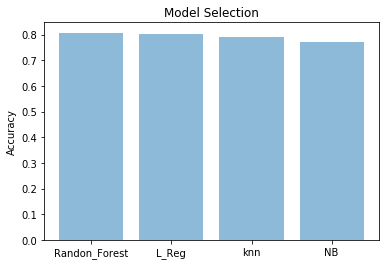

In [48]:
objects = ('Randon_Forest', 'L_Reg', 'knn', 'NB')
y_pos = np.arange(len(objects))

plt.bar(y_pos, Best_Score, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Model Selection')

plt.show()